### the code presented in this notebook performs time series forecasting for Russell 2000 in order to infer the trend of the index in the immediate future

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### The Data

Russell 2000 data was taken from https://finance.yahoo.com/

In [2]:
# loading Russell 2000 dataset
russell_2000 = pd.read_csv('C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/russell_2000_frequency_B.csv')

In [3]:
russell_2000.info() # observed that 'Date' column is of 'object' dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              1095 non-null   object 
 1   Open              1095 non-null   float64
 2   High              1095 non-null   float64
 3   Low               1095 non-null   float64
 4   Close             1095 non-null   float64
 5   Adj Close         1095 non-null   float64
 6   Range             1095 non-null   float64
 7   daily_delta       1095 non-null   float64
 8   percentage_delta  1095 non-null   float64
 9   Volume            1095 non-null   int64  
 10  Event             1095 non-null   int64  
 11  Category          1095 non-null   int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 102.8+ KB


In [4]:
# converting the 'Date' column to a datetime object and setting it as the index with 'daily' frequency
russell_2000 = russell_2000.set_index(pd.to_datetime(russell_2000['Date'])).drop('Date', axis = 1)
# specifying that time series data follows the business days (Monday through Friday) cadence, so that we can fit ARMA nicely 
russell_2000 = russell_2000.asfreq('B')

In [5]:
# running diagnostic for how russell_2000 dataframe looks like now
print(russell_2000.info())
print(type(russell_2000))
print(len(russell_2000))
print(russell_2000.shape)
print(russell_2000.dtypes) # this is covered by .info() function, but running it to double confirm expected output
russell_2000.sample()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2020-01-06 to 2024-03-15
Freq: B
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1095 non-null   float64
 1   High              1095 non-null   float64
 2   Low               1095 non-null   float64
 3   Close             1095 non-null   float64
 4   Adj Close         1095 non-null   float64
 5   Range             1095 non-null   float64
 6   daily_delta       1095 non-null   float64
 7   percentage_delta  1095 non-null   float64
 8   Volume            1095 non-null   int64  
 9   Event             1095 non-null   int64  
 10  Category          1095 non-null   int64  
dtypes: float64(8), int64(3)
memory usage: 102.7 KB
None
<class 'pandas.core.frame.DataFrame'>
1095
(1095, 11)
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Range

,Open,High,Low,Close,Adj Close,Range,daily_delta,percentage_delta,Volume,Event,Category
Date,,,,,,,,,,,
2021-04-02,2225.290039,2253.899902,2225.290039,2253.899902,2253.899902,28.609863,33.379882,1.503246,4162130000,0,0


In [6]:
# confirming that there is no corrupted values
russell_2000.isnull().sum()

Open                0
High                0
Low                 0
Close               0
Adj Close           0
Range               0
daily_delta         0
percentage_delta    0
Volume              0
Event               0
Category            0
dtype: int64

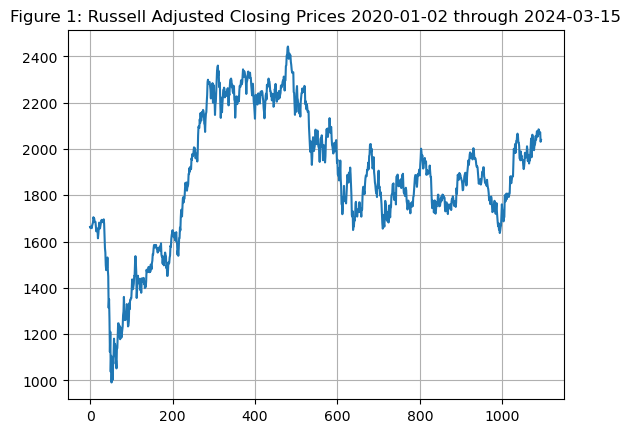

In [7]:
plt.plot(russell_2000['Adj Close'].values) # in total 1095 data points along X-axis
plt.title('Figure 1: Russell Adjusted Closing Prices 2020-01-02 through 2024-03-15')
plt.grid()
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v01.png")

In [8]:
# subsetting the data to only 'Adj Close' column and assigning as a DataFrame
russell_2000 = russell_2000[['Adj Close']]

In [9]:
# running diagnostic for how russell_2000 dataframe looks like now
print(russell_2000.info())
print(type(russell_2000))
print(len(russell_2000))
print(russell_2000.shape)
print(russell_2000.dtypes) # this is covered by .info() function, but running it to double confirm expected output
russell_2000.sample()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2020-01-06 to 2024-03-15
Freq: B
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1095 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB
None
<class 'pandas.core.frame.DataFrame'>
1095
(1095, 1)
Adj Close    float64
dtype: object


,Adj Close
Date,
2020-09-14,1536.969971


In [16]:
# run this if you'd like to transfor the data to the first difference of the logarithm so as to form a stationary series
russell_2000 = np.log(russell_2000).diff().dropna()

In [10]:
# running augmented Dicky Fuller to check for data stationarity
# it seems like null hypothesis can be rejected based on statistic being outside of threshold values
results = adfuller(russell_2000)
results

(-1.769370058423045,
 0.3957711045556225,
 9,
 1085,
 {'1%': -3.436391325753478,
  '5%': -2.864207498909067,
  '10%': -2.5681902663042324},
 10340.657655309325)

In [13]:
# splitting the data where the train_data is all but the last 105 days Russell 2000 performance
X_train, X_test = russell_2000.iloc[:-105], russell_2000.iloc[-105:]

# confirming the expected outcome of the data split
print(X_train.head())
print(X_train.tail())
print(X_test.head())
print(X_test.tail()) # yep, things look correct (Oct. 21, '23 & Oct 22, '23 are weekend days)

              Adj Close
Date                   
2020-01-06  1663.260010
2020-01-07  1658.310059
2020-01-08  1663.589966
2020-01-09  1664.989990
2020-01-10  1657.640015
              Adj Close
Date                   
2023-10-16  1747.060059
2023-10-17  1766.050049
2023-10-18  1728.810059
2023-10-19  1702.699951
2023-10-20  1680.790039
              Adj Close
Date                   
2023-10-23  1665.880005
2023-10-24  1679.500000
2023-10-25  1651.430054
2023-10-26  1657.000000
2023-10-27  1636.939941
              Adj Close
Date                   
2024-03-11  2065.879883
2024-03-12  2065.479980
2024-03-13  2071.709961
2024-03-14  2031.180054
2024-03-15  2039.319946


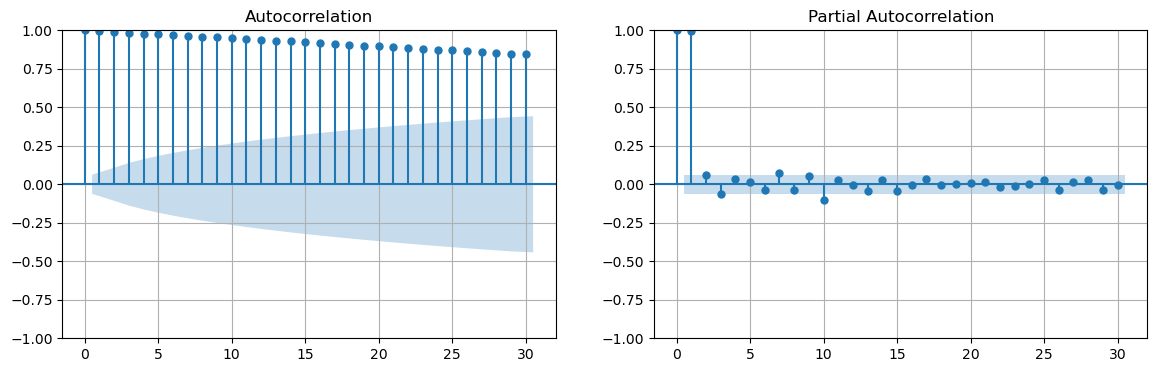

In [14]:
# plotting acf and pacf to attemp to identify p and q parameters for ARMA model
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
plot_acf(X_train, ax = ax[0]);
ax[0].grid()
plot_pacf(X_train, ax = ax[1])
ax[1].grid()
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v02.png")

In [15]:
# initializing and training the AutoRegressive Moving Average model
arma = ARIMA(X_train['Adj Close'], order=(1, 0, 1)).fit()
# arma = ARIMA(russell_2000, order=(1, 0, 1)).fit()
# checking for the expected outcome
print(arma)

Date
2021-11-04    2399.259968
Freq: B, Name: predicted_mean, dtype: float64


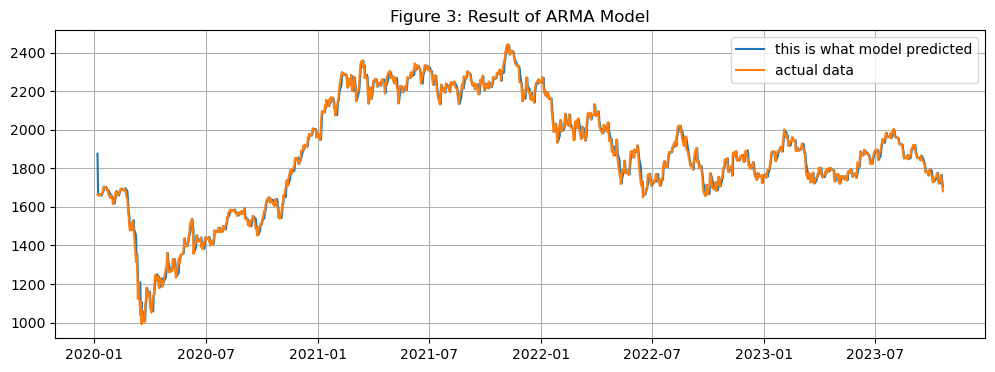

In [16]:
# running prediction

hist_preds = arma.predict()

print(hist_preds.sample())

plt.figure(figsize = (12, 4))
plt.plot(hist_preds, label = 'this is what model predicted')
plt.plot(X_train, label = 'actual data')
plt.legend()
plt.grid()
plt.title('Figure 3: Result of ARMA Model')
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v03.png")

In [17]:
# now, let's perform forecasting
future_preds = arma.forecast(steps = len(X_test))

# checking for the expected output ... ok! values generated, timestamp assigned
print(future_preds.tail())
print(type(future_preds))

2024-03-11    1755.464125
2024-03-12    1756.029402
2024-03-13    1756.592019
2024-03-14    1757.151989
2024-03-15    1757.709324
Freq: B, Name: predicted_mean, dtype: float64
<class 'pandas.core.series.Series'>


In [18]:
print(len(future_preds))
print(type(future_preds))

105
<class 'pandas.core.series.Series'>


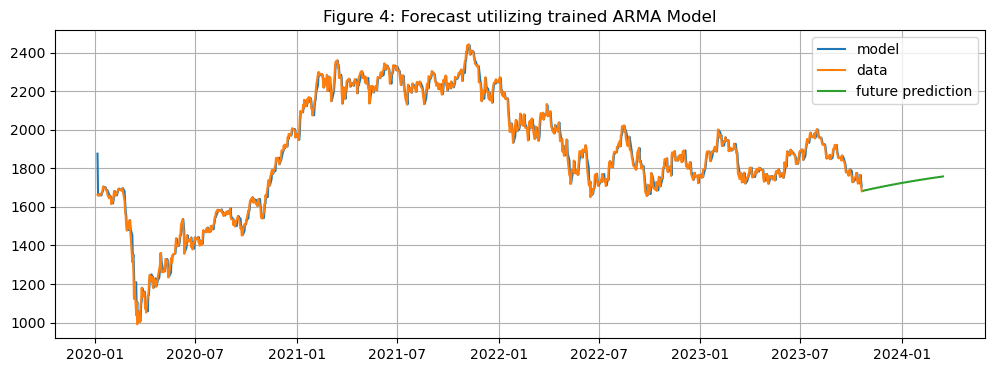

In [19]:
# visualizing it all together with forecased values
plt.figure(figsize = (12, 4))
plt.plot(hist_preds, label = 'model')
plt.plot(X_train, label = 'data')
plt.plot(future_preds, label = 'future prediction')
plt.legend()
plt.grid()
plt.title('Figure 4: Forecast utilizing trained ARMA Model')
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v04.png")

In [20]:
# analyzing model's performance

forecasting_error = X_test['Adj Close'] - future_preds.values
mae = np.abs(forecasting_error).mean()
rmse = np.sqrt((forecasting_error**2).mean())

# checking for expected outcome
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 201.62153433323465
RMSE: 225.36220142912993
